### Import Statsbomb dataset with other libraries

In [1]:
from statsbombpy import sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trueskill
import scipy.stats as stats
from scipy.stats import truncnorm, norm

### Import the data of the matches played during Euro24 

In [4]:
df_comp = sb.competitions() 
df_euro = df_comp[df_comp['competition_name'] == "UEFA Euro"]
matches = sb.matches(competition_id=55, season_id=282)
matches.head()

/home/travail/playground/APML_env/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3942819,2024-07-10,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,England,1,2,available,...,2024-07-15T07:57:36.684453,6,Semi-finals,Signal-Iduna-Park,Felix Zwayer,Ronald Koeman,Gareth Southgate,1.1.0,2,2
1,3943043,2024-07-14,22:00:00.000,Europe - UEFA Euro,2024,Spain,England,2,1,available,...,2024-07-15T15:52:24.778809,7,Final,Olympiastadion Berlin,François Letexier,Luis de la Fuente Castillo,Gareth Southgate,1.1.0,2,2
2,3942752,2024-07-09,22:00:00.000,Europe - UEFA Euro,2024,Spain,France,2,1,available,...,2024-07-10T13:01:26.597509,6,Semi-finals,Allianz Arena,Slavko Vinčić,Luis de la Fuente Castillo,Didier Deschamps,1.1.0,2,2
3,3942382,2024-07-06,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,Turkey,2,1,available,...,2024-07-10T06:56:35.146850,5,Quarter-finals,Olympiastadion Berlin,Clément Turpin,Ronald Koeman,Vincenzo Montella,1.1.0,2,2
4,3942349,2024-07-05,22:00:00.000,Europe - UEFA Euro,2024,Portugal,France,0,0,available,...,2024-07-12T02:00:16.871522,5,Quarter-finals,Volksparkstadion,Michael Oliver,Roberto Martínez Montoliú,Didier Deschamps,1.1.0,2,2


### Lets process the data so that only the date, time, team names, and scores are organized in a separate table

In [5]:
# Select and rename relevant columns
data = matches[['home_team', 'away_team', 'home_score', 'away_score']]
data.rename(columns={
    'home_team': 'team1',
    'away_team': 'team2',
    'home_score': 'score1',
    'away_score': 'score2'
}, inplace=True)

data.head()


/tmp/ipykernel_5234/1553709952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={


,team1,team2,score1,score2
0,Netherlands,England,1,2
1,Spain,England,2,1
2,Spain,France,2,1
3,Netherlands,Turkey,2,1
4,Portugal,France,0,0


In [6]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values if any
data.dropna(inplace=True)

team1     0
team2     0
score1    0
score2    0
dtype: int64


/tmp/ipykernel_5234/3449500983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [7]:
# Ensure scores are integers
data['score1'] = data['score1'].astype(int)
data['score2'] = data['score2'].astype(int)

/tmp/ipykernel_5234/905000424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['score1'] = data['score1'].astype(int)
/tmp/ipykernel_5234/905000424.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['score2'] = data['score2'].astype(int)


In [8]:
# Create a list of unique teams
teams = pd.unique(data[['team1', 'team2']].values.ravel())
print("Teams involved:", teams)

Teams involved: ['Netherlands' 'England' 'Spain' 'France' 'Turkey' 'Portugal' 'Austria'
 'Denmark' 'Switzerland' 'Germany' 'Ukraine' 'Belgium' 'Czech Republic'
 'Romania' 'Slovenia' 'Georgia' 'Slovakia' 'Serbia' 'Albania' 'Italy'
 'Scotland' 'Hungary' 'Croatia' 'Poland']


In [9]:
# Initialize TrueSkill environment with zero draw probability
env = trueskill.TrueSkill(draw_probability=0)

# Dictionary to store ratings for each team
ratings = {}

In [10]:
# Initialize each team's rating
for team in teams:
    ratings[team] = env.create_rating()

ratings # Each team starts with equal rating

{'Netherlands': trueskill.Rating(mu=25.000, sigma=8.333),
 'England': trueskill.Rating(mu=25.000, sigma=8.333),
 'Spain': trueskill.Rating(mu=25.000, sigma=8.333),
 'France': trueskill.Rating(mu=25.000, sigma=8.333),
 'Turkey': trueskill.Rating(mu=25.000, sigma=8.333),
 'Portugal': trueskill.Rating(mu=25.000, sigma=8.333),
 'Austria': trueskill.Rating(mu=25.000, sigma=8.333),
 'Denmark': trueskill.Rating(mu=25.000, sigma=8.333),
 'Switzerland': trueskill.Rating(mu=25.000, sigma=8.333),
 'Germany': trueskill.Rating(mu=25.000, sigma=8.333),
 'Ukraine': trueskill.Rating(mu=25.000, sigma=8.333),
 'Belgium': trueskill.Rating(mu=25.000, sigma=8.333),
 'Czech Republic': trueskill.Rating(mu=25.000, sigma=8.333),
 'Romania': trueskill.Rating(mu=25.000, sigma=8.333),
 'Slovenia': trueskill.Rating(mu=25.000, sigma=8.333),
 'Georgia': trueskill.Rating(mu=25.000, sigma=8.333),
 'Slovakia': trueskill.Rating(mu=25.000, sigma=8.333),
 'Serbia': trueskill.Rating(mu=25.000, sigma=8.333),
 'Albania': tru

### Monte-Carlo Simulation

In [11]:
def monte_carlo_win_probability(team1_rating, team2_rating, num_simulations=10000):
    """
    Estimates the probability that team1 wins against team2 using Monte Carlo simulation.

    Parameters:
    - team1_rating: TrueSkill rating object for team1.
    - team2_rating: TrueSkill rating object for team2.
    - num_simulations: Number of simulations to run.

    Returns:
    - Probability that team1 wins.
    """
    team1_wins = 0

    # Extract mu and sigma for both teams
    mu1, sigma1 = team1_rating.mu, team1_rating.sigma
    mu2, sigma2 = team2_rating.mu, team2_rating.sigma

    for _ in range(num_simulations):
        # Sample performance from normal distributions
        perf1 = np.random.normal(mu1, sigma1)
        perf2 = np.random.normal(mu2, sigma2)

        # Increment team1_wins if team1's performance is higher
        if perf1 > perf2:
            team1_wins += 1

    # Calculate win probability
    win_probability = team1_wins / num_simulations

    return win_probability


In [12]:
# Lists to store results for analysis
predictions = []
actual_results = []

# Iterate over each match
for index, row in data.iterrows():
    # Extract teams and scores
    team1 = row['team1']
    team2 = row['team2']
    score1 = row['score1']
    score2 = row['score2']

    # Get current ratings
    team1_rating = ratings[team1]
    team2_rating = ratings[team2]

    # Step 1: Predict the outcome using Monte Carlo simulation
    win_prob = monte_carlo_win_probability(team1_rating, team2_rating)

    # Make a deterministic prediction based on win probability
    if win_prob > 0.5:
        prediction = +1  # Predict team1 wins
    else:
        prediction = -1  # Predict team2 wins

    # Append prediction
    predictions.append(prediction)

    # Step 2: Determine the actual outcome
    if score1 > score2:
        actual_result = +1  # Team 1 won
    elif score1 < score2:
        actual_result = -1  # Team 2 won
    else:
        # Match was a draw
        actual_result = 0   # We will exclude this match from analysis


    actual_results.append(actual_result)

    # Step 3: Update the TrueSkill ratings with the actual match result
    if actual_result == +1:
        # Team 1 won
        ratings[team1], ratings[team2] = env.rate_1vs1(team1_rating, team2_rating)
    elif actual_result == -1:
        # Team 2 won
        ratings[team2], ratings[team1] = env.rate_1vs1(team2_rating, team1_rating)


# Convert to numpy arrays
predictions = np.array(predictions)
actual_results = np.array(actual_results)

# Exclude matches that ended in a draw from accuracy calculation
non_draw_indices = actual_results != 0

# Calculate accuracy
accuracy = np.mean(predictions[non_draw_indices] == actual_results[non_draw_indices])

print(f'Prediction Accuracy (excluding draws): {accuracy * 100:.2f}%')


Prediction Accuracy (excluding draws): 52.94%


### Gibbs Sampling

In [27]:
# Initialize parameters
initial_mean_skill = 25.0  # Initial mean skill for each team
initial_variance = 25.0 / 3  # Initial variance for each team's skill
sigma_t = 1.0  # Standard deviation for match outcomes

# Initialize skills for each team
teams = set(data['team1']).union(set(data['team2']))
skills = {team: [initial_mean_skill, np.sqrt(initial_variance)] for team in teams}
skills

{'Italy': [25.0, np.float64(2.886751345948129)],
 'France': [25.0, np.float64(2.886751345948129)],
 'Croatia': [25.0, np.float64(2.886751345948129)],
 'Germany': [25.0, np.float64(2.886751345948129)],
 'Switzerland': [25.0, np.float64(2.886751345948129)],
 'Turkey': [25.0, np.float64(2.886751345948129)],
 'Scotland': [25.0, np.float64(2.886751345948129)],
 'Ukraine': [25.0, np.float64(2.886751345948129)],
 'Belgium': [25.0, np.float64(2.886751345948129)],
 'Spain': [25.0, np.float64(2.886751345948129)],
 'Czech Republic': [25.0, np.float64(2.886751345948129)],
 'Austria': [25.0, np.float64(2.886751345948129)],
 'Romania': [25.0, np.float64(2.886751345948129)],
 'Hungary': [25.0, np.float64(2.886751345948129)],
 'Georgia': [25.0, np.float64(2.886751345948129)],
 'Slovakia': [25.0, np.float64(2.886751345948129)],
 'Poland': [25.0, np.float64(2.886751345948129)],
 'Portugal': [25.0, np.float64(2.886751345948129)],
 'Albania': [25.0, np.float64(2.886751345948129)],
 'Slovenia': [25.0, np.f

In [28]:
# Function to sample t given s1 and s2
def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Function to sample s = [s1, s2] given t using joint normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2, sigma_t):
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Precompute components for efficiency
    A = np.array([[1, -1]])
    Sigma_s_inv = np.array([[1 / variance_s1, 0], [0, 1 / variance_s2]])
    
    inv_sigma_t = 1 / (sigma_t**2)
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + Sigma_s_inv)
    
    # Ensure the mean vector is one-dimensional
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t * t + Sigma_s_inv @ np.array([[mu_1], [mu_2]]))

    # Convert the mean vector to a 1D array
    mean_s_given_t = mean_s_given_t.flatten()

    # Draw a sample from the conditional distribution
    return np.random.multivariate_normal(mean_s_given_t, cov_s_given_t)

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = np.zeros(num_samples)
    s2_samples = np.zeros(num_samples)

    # Initialize first samples
    s1_samples[0] = initial_s1[0]
    s2_samples[0] = initial_s2[0]

    for i in range(1, num_samples):
        s1_current = s1_samples[i - 1]
        s2_current = s2_samples[i - 1]
        
        t_new = sample_t(s1_current, s2_current, sigma_t)
        
        # Sample s given t
        while True:
            s_new = sample_s_given_t(t_new, initial_s1[0], initial_s2[0], initial_s1[1], initial_s2[1], sigma_t)

            if s_new[0] > s_new[1]:  # Ensure s1 > s2
                s1_samples[i] = s_new[0]
                s2_samples[i] = s_new[1]
                break

    return s1_samples[burn_in:], s2_samples[burn_in:]

# Parameters for Gibbs sampling
num_samples = 10000
burn_in = 500  # Number of samples to discard


for idx, row in data.iterrows():
    team1, team2 = row['team1'], row['team2']
    score1, score2 = row['score1'], row['score2']

    # Skip draws
    if score1 == score2:
        continue

    # Get initial skills for teams
    s1_initial = skills[team1]
    s2_initial = skills[team2]

    print(f"Initial skills for {team1}: Mean = {s1_initial[0]}, Variance = {s1_initial[1]**2}")
    print(f"Initial skills for {team2}: Mean = {s2_initial[0]}, Variance = {s2_initial[1]**2}")

    # Perform Gibbs sampling
    if score1 > score2:
        s1_samples, s2_samples = gibbs_sampling(num_samples, burn_in, s1_initial, s2_initial)
    else:
        s2_samples, s1_samples = gibbs_sampling(num_samples, burn_in, s2_initial, s1_initial)

    skills[team1] = [np.mean(s1_samples), np.std(s1_samples)]
    skills[team2] = [np.mean(s2_samples), np.std(s2_samples)]

    print(f"Updated skills for {team1}: Mean = {skills[team1][0]}, Variance = {skills[team1][1]**2}")
    print(f"Updated skills for {team2}: Mean = {skills[team2][0]}, Variance = {skills[team2][1]**2}")
    print()

Initial skills for Netherlands: Mean = 25.0, Variance = 8.333333333333336
Initial skills for England: Mean = 25.0, Variance = 8.333333333333336
Updated skills for Netherlands: Mean = 23.391794646169714, Variance = 5.6643587926995895
Updated skills for England: Mean = 26.58449936294973, Variance = 5.61254068021547

Initial skills for Spain: Mean = 25.0, Variance = 8.333333333333336
Initial skills for England: Mean = 26.58449936294973, Variance = 5.61254068021547
Updated skills for Spain: Mean = 27.492238266827865, Variance = 4.874750727576731
Updated skills for England: Mean = 24.914439473357792, Variance = 3.9304559977961255

Initial skills for Spain: Mean = 27.492238266827865, Variance = 4.874750727576731
Initial skills for France: Mean = 25.0, Variance = 8.333333333333336
Updated skills for Spain: Mean = 28.054904747997675, Variance = 4.159945968760151
Updated skills for France: Mean = 23.99896307091579, Variance = 6.206683278143268

Initial skills for Netherlands: Mean = 23.39179464

### Truncated Normal

In [15]:
# Initialize parameters
initial_mean_skill = 25.0  # Initial mean skill for each team
initial_variance = 25.0 / 3  # Initial variance for each team's skill
sigma_t = 1.0  # Standard deviation for match outcomes

# Initialize skills for each team
teams = set(data['team1']).union(set(data['team2']))
skills = {team: [initial_mean_skill, np.sqrt(initial_variance)] for team in teams}

# Function to sample t given s1 and s2
def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Truncated Gaussian helper function for sampling with truncation
def truncated_gaussian(mean, std, lower_bound, upper_bound):
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)

# Function to sample s = [s1, s2] given t using truncated normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2, sigma_t):
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Precompute components for efficiency
    A = np.array([[1, -1]])
    Sigma_s_inv = np.array([[1 / variance_s1, 0], [0, 1 / variance_s2]])
    
    inv_sigma_t = 1 / (sigma_t**2)
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + Sigma_s_inv)
    
    # Ensure the mean vector is one-dimensional
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t * t + Sigma_s_inv @ np.array([[mu_1], [mu_2]]))
    mean_s_given_t = mean_s_given_t.flatten()

    # Draw samples from the truncated normal distribution for s1 > s2
    s_diff_mean = mean_s_given_t[0] - mean_s_given_t[1]
    s_diff_std = np.sqrt(cov_s_given_t[0, 0] + cov_s_given_t[1, 1] - 2 * cov_s_given_t[0, 1])
    
    # Truncate so that s1 - s2 > 0
    s_diff = truncated_gaussian(s_diff_mean, s_diff_std, 0, np.inf)
    
    # Sample s2 and compute s1 = s2 + s_diff
    s2 = np.random.normal(mean_s_given_t[1], np.sqrt(cov_s_given_t[1, 1]))
    s1 = s2 + s_diff

    return [s1, s2]

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = np.zeros(num_samples)
    s2_samples = np.zeros(num_samples)

    # Initialize first samples
    s1_samples[0] = initial_s1[0]
    s2_samples[0] = initial_s2[0]

    for i in range(1, num_samples):
        s1_current = s1_samples[i - 1]
        s2_current = s2_samples[i - 1]
        
        t_new = sample_t(s1_current, s2_current, sigma_t)
        
        # Sample s given t using truncated Gaussian
        s_new = sample_s_given_t(t_new, initial_s1[0], initial_s2[0], initial_s1[1], initial_s2[1], sigma_t)
        s1_samples[i] = s_new[0]
        s2_samples[i] = s_new[1]

    return s1_samples[burn_in:], s2_samples[burn_in:]

# Parameters for Gibbs sampling
num_samples = 10000
burn_in = 500  # Number of samples to discard


for idx, row in data.iterrows():
    team1, team2 = row['team1'], row['team2']
    score1, score2 = row['score1'], row['score2']

    # Skip draws
    if score1 == score2:
        continue

    # Get initial skills for teams
    s1_initial = skills[team1]
    s2_initial = skills[team2]

    # Perform Gibbs sampling
    if score1 > score2:
        s1_samples, s2_samples = gibbs_sampling(num_samples, burn_in, s1_initial, s2_initial)
    else:
        s2_samples, s1_samples = gibbs_sampling(num_samples, burn_in, s2_initial, s1_initial)

    skills[team1] = [np.mean(s1_samples), np.std(s1_samples)]
    skills[team2] = [np.mean(s2_samples), np.std(s2_samples)]

skills

{'Italy': [np.float64(25.14538380022447), np.float64(2.138179882860077)],
 'France': [np.float64(26.968455910196106), np.float64(1.9530355675852615)],
 'Croatia': [np.float64(24.391936836208693), np.float64(2.735022313910014)],
 'Germany': [np.float64(28.047903878543366), np.float64(2.2612930817196495)],
 'Switzerland': [np.float64(27.67743758213555), np.float64(2.166726025609066)],
 'Turkey': [np.float64(25.019527550756678), np.float64(1.6688301990398775)],
 'Scotland': [np.float64(23.09261096360519), np.float64(2.2849437478230494)],
 'Ukraine': [np.float64(24.2521454331869), np.float64(1.8998004509745228)],
 'Belgium': [np.float64(24.896806210807867), np.float64(1.6384188641251418)],
 'Spain': [np.float64(30.280513158802165), np.float64(2.56331194276422)],
 'Czech Republic': [np.float64(22.257197625172978),
  np.float64(2.1173394310848677)],
 'Austria': [np.float64(25.036603477885247), np.float64(1.8097552301221758)],
 'Romania': [np.float64(23.65816960973507), np.float64(1.591754179

### Factor graph & Message-Passing Algorithm

In [16]:
def mutiplyGauss (m1 , s1,  m2 , s2):

  s = 1/(1/s1 + 1/s2)
  m = (m1/s1 + m2/s2)*s

  return m, s

def divideGauss (m1 , s1 , m2 , s2):

  m, s = mutiplyGauss(m1 , s1 , m2 , s2)

  return m, s

def truncGaussMM (a, b, m0 , s0):

  a_scaled , b_scaled = (a - m0)/np.sqrt(s0), (b - m0)/np.sqrt(s0)
  m = truncnorm.mean(a_scaled, b_scaled, loc=m0, scale =np.sqrt(s0))
  s = truncnorm.var(a_scaled, b_scaled, loc=m0, scale =np.sqrt(s0))

  return m, s


In [17]:
def message_passing(y, m1, v1, m2, v2, vt):
    # message from factor f_s1(s1) to node s1
    mu3_m = m1
    mu3_v = v1

    # message from factor f_s2(s2) to node s2
    mu5_m = m2
    mu5_v = v2

    # message from nodes s1 to factor f_st(t)
    mu4_m = mu3_m
    mu4_v = mu3_v
    # message from nodes s1 to factor f_st(t)
    mu6_m = mu5_m
    mu6_v = mu5_v

    # message from factor f_st(t) to node t
    mu7_m = m1-m2
    mu7_v = v1+v2+vt

    # moment matcing
    if y == 1:
        a, b = 0, np.inf
    else:
        a, b = np.NINF , 0

    pt_m, pt_v = truncGaussMM(a, b, mu7_m, mu7_v)
    # outgoing message from node t to factor f_st(t)
    mu8_m, mu8_v = divideGauss(pt_m,  pt_v, mu7_m, mu7_v)

    # message from factor f_st(t) to node s1
    mu9_m = mu8_m + m2
    mu9_v = mu8_v + vt + v2

    # message from factor f_st(t) to node s2
    mu10_m = m1 - mu8_m
    mu10_v = mu8_v + vt + v1

    # compute the marginal of s1 and s2
    p1_m , p1_v = mutiplyGauss(mu3_m, mu3_v, mu9_m, mu9_v)
    p2_m , p2_v = mutiplyGauss(mu5_m, mu5_v, mu10_m, mu10_v)

    return p1_m , p1_v, p2_m , p2_v

In [19]:
y=1
m1 = 25
m2 = 25
v1 = (25/3)**2
v2 = (25/3)**2
vt = (25/3)**2
p1_m, p1_v, p2_m, p2_v = message_passing(y, m1, v1, m2, v2, vt)
num_samples = 500
burn_in = 20
x = np.linspace(m1-v1, m1+v1, num_samples-burn_in)

s1_pdf = norm.pdf(x,p1_m,np.sqrt(p1_v))
s2_pdf = norm.pdf(x,p2_m,np.sqrt(p2_v))

In [23]:
def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Function to sample s = [s1, s2] given t using joint normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2):
    # Compute the conditional means and variances
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Define A matrix and b vector
    A = np.array([[1, -1]])  # For the linear combination t = s1 - s2
    Sigma_s = np.array([[variance_s1, 0], [0, variance_s2]])  # Covariance matrix for s1 and s2
    b = np.array([t])

    # Conditional distribution of s given t
    inv_sigma_t = 1 / (sigma_t**2)  # Inverse of scalar sigma_t^2
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + np.linalg.inv(Sigma_s))
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t @ b + np.linalg.inv(Sigma_s) @ np.array([mu_1, mu_2]))

    # Draw a sample from the conditional distribution
    return np.random.multivariate_normal(mean_s_given_t, cov_s_given_t)

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = [initial_s1]
    s2_samples = [initial_s2]
    t_samples = []

    # Iterate to generate samples
    for _ in range(num_samples):
        # Sample t given s1 and s2
        s1_current = s1_samples[-1]
        s2_current = s2_samples[-1]
        t_new = sample_t(s1_current, s2_current, sigma_t)
        t_samples.append(t_new)

        # Sample s = [s1, s2] given t, with rejection if s1 <= s2
        while True:
            s_new = sample_s_given_t(t_new, initial_s1, initial_s2, initial_s1, initial_s2)
            if s_new[0] > s_new[1]:  # Ensure s1 > s2
                s1_samples.append(s_new[0])
                s2_samples.append(s_new[1])
                break

    # Discard the burn-in samples
    return s1_samples[burn_in:], s2_samples[burn_in:], t_samples[burn_in:]

In [24]:
mu_1 = 25
sigma_1 =25/3
mu_2 = 25
sigma_2 = 25/3
sigma_t = 25/3
initial_s1 = 25
initial_s2 = 25

# Gibbs sampling
s1_samples, s2_samples, _= gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2)

In [25]:
s1_gibbs_pdf = norm.pdf(x,np.mean(s1_samples),np.std(s1_samples))
s2_gibbs_pdf  = norm.pdf(x,np.mean(s2_samples),np.std(s2_samples))

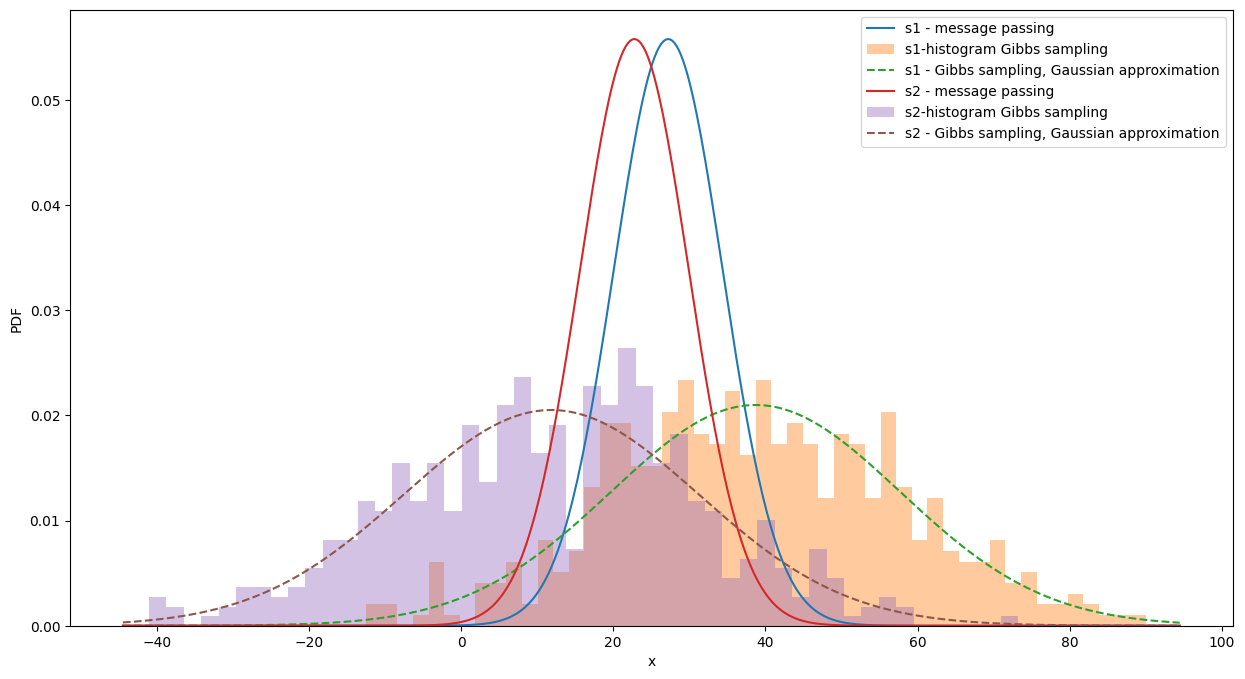

In [26]:
# plot the posteriors computed with message passing, the histogram and the Gaussian approximation from Gibbs sampling for player 1
plt.figure(figsize=(15, 8))
plt.plot(x,s1_pdf,'-',label = 's1 - message passing')
plt.hist(s1_samples, label='s1-histogram Gibbs sampling',density = True,bins=50, alpha = 0.4)
plt.plot(x,s1_gibbs_pdf,'--',label = "s1 - Gibbs sampling, Gaussian approximation")


# plot the posteriors computed with message passing, the histogram and the Gaussian approximation from Gibbs sampling for player 1
plt.plot(x,s2_pdf,'-',label = 's2 - message passing')
plt.hist(s2_samples, label='s2-histogram Gibbs sampling',density = True,bins=50, alpha = 0.4)
plt.plot(x,s2_gibbs_pdf,'--',label = "s2 - Gibbs sampling, Gaussian approximation")

plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.show()
     